In [1]:
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

DEVICE = "cuda"

In [2]:
def gen_synthetic_data(N=50):
    xs=ys=-2
    xe=ye=2
    
    X1 = np.linspace(xs,xe,N)
    X2 = np.linspace(ys,ye,N)
    
    X = np.meshgrid(X1,X2)
    X = np.stack([x.ravel()[:None] for x in X], axis=-1)
    
    Y = ((np.square(X[:,0]) + np.square(X[:,1])) <= 1).astype("int")

    return torch.from_numpy(X).float(), torch.from_numpy(Y)

In [3]:
class NeuralNet(nn.Module):
    def __init__(self, non_linear_activation=nn.ReLU(), input_dim=2, output_dim=2):
        super().__init__()
        self.non_linear_activation = non_linear_activation

        self.f = nn.Sequential(
            nn.Linear(input_dim, 10),
            self.non_linear_activation,
            nn.Linear(10, output_dim),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, x):
        return self.f(x)

In [4]:
def train(N=40):
    data,labels=gen_synthetic_data(N=N)
    data = data.to(DEVICE)
    labels = labels.to(DEVICE)

    net = NeuralNet().to(DEVICE)
    loss_fn = nn.NLLLoss()
    optim = torch.optim.Adam(net.parameters())

    EPOCHS = 30
    BATCH = 50

    ls = []

    for epoch in range(EPOCHS):
        eloss = 0
        for b in range(100):
            indexes = torch.randperm(data.shape[0])[:BATCH]
            batch = data[indexes]
            target = labels[indexes]
            
            out = net(batch)
            loss = loss_fn(out, target)
            
            optim.zero_grad()
            loss.backward()
            optim.step()

            eloss += loss.item()

        tloss = eloss / data.shape[0]
        ls.append(tloss)

    return data,labels,net,ls

In [5]:
data,labels,net,ls = train(N=35)

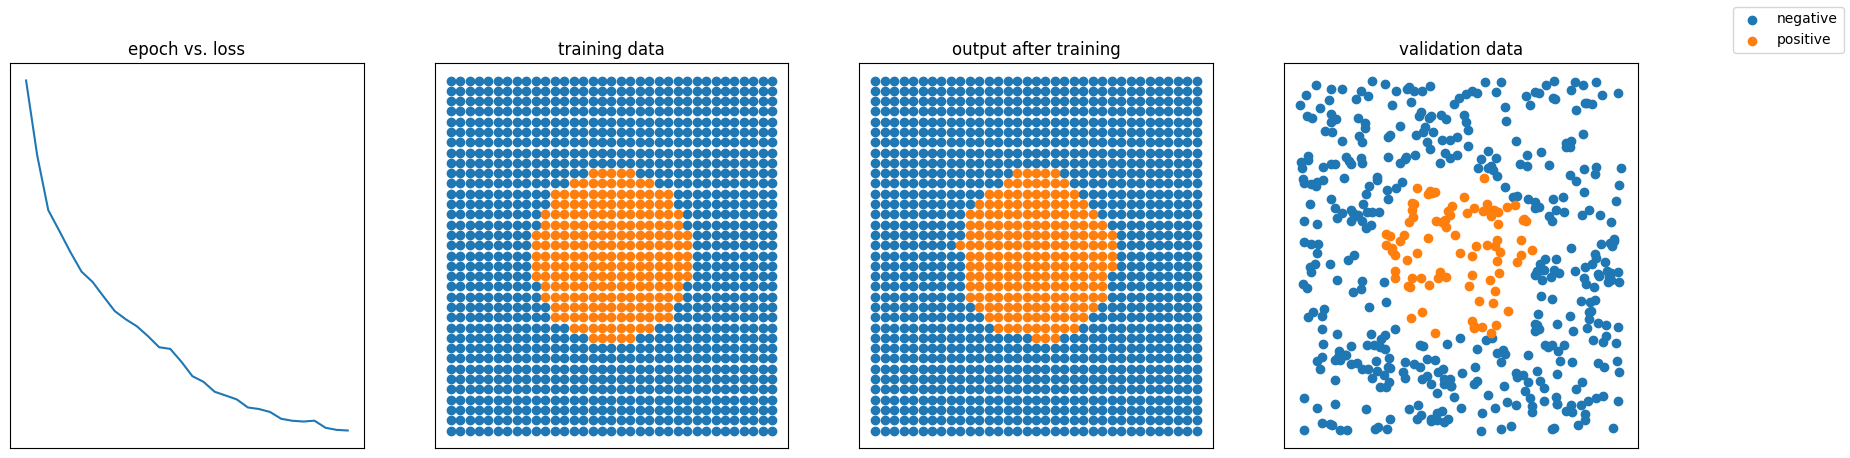

In [6]:
output=None
with torch.no_grad():
    output = torch.argmax(net(data), dim=-1).cpu().numpy()
X = data.cpu().numpy()

valid_data = ((torch.rand((500,2)) - 0.5) * 4).to(DEVICE)
output_valid=None
with torch.no_grad():
    output_valid = torch.argmax(net(valid_data), dim=-1).cpu().numpy()

fig,arr = plt.subplots(1,4,figsize=(21,5))

for a in arr:
    a.set_xticks([])
    a.set_yticks([])

arr[0].plot(np.arange(len(ls)),ls)
arr[0].set_title("epoch vs. loss")

for i in range(2):
    ind_i = labels.cpu() == i
    arr[1].scatter(X[ind_i,0], X[ind_i,1], label="positive" if i > 0 else "negative")
    arr[1].set_title("training data")

fig.legend()

for i in range(2):
    ind_i = output == i
    arr[2].scatter(X[ind_i,0], X[ind_i,1], label=i)
    arr[2].set_title("output after training")

for i in range(2):
    ind_i = output_valid == i
    arr[3].scatter(valid_data[ind_i,0].cpu(), valid_data[ind_i,1].cpu(), label=i)
    arr[3].set_title("validation data")

plt.show()

In [7]:
import pytorch_influence_functions as ptif
from torch.utils.data import DataLoader

In [8]:
def get_test_pt(point):
    x1,x2=point
    norm = np.square(x1) + np.square(x2)
    lab = 1 if norm <= 1 else 0
    return (torch.tensor([x1,x2]).to(DEVICE).float(), torch.tensor(lab).to(DEVICE))

TESTX = (0,0)

train_data = DataLoader([(x,y) for x,y in zip(data, labels)], batch_size=1, shuffle=False)
# test_data = DataLoader([(x,y) for x,y in zip(data[0:1], labels[0:1])], batch_size=1, shuffle=False)
test_data = DataLoader([get_test_pt(TESTX)], batch_size=1, shuffle=False)

In [9]:
config = ptif.get_default_config()

influence, harmful, helpful, _ = ptif.calc_influence_function.calc_influence_single(
    net, train_data, test_data, test_id_num=0, gpu=config['gpu'],
    recursion_depth=config['recursion_depth'], r=config['r_averaging'])

Calc. s_test recursions: [=================================================] 1 / 1
Averaging r-times: [=======================================================] 1 / 1
Calc. influence function: [==========================================] 1224 / 1225225
Calc. influence function: [==========================================] 1225 / 1225


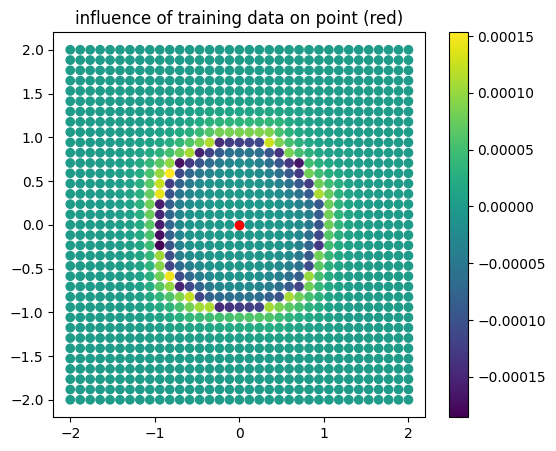

In [10]:
X = data.cpu().numpy()
fig, arr = plt.subplots(1,1,figsize=(6,5))
scatter = arr.scatter(X[:,0], X[:,1], c=influence)
arr.scatter(TESTX[0], TESTX[1], c="red")
fig.colorbar(scatter)
plt.title("influence of training data on point (red)")
plt.show()

In [ ]:
# does out of sample data correlate with abnormally high influence
# Can influence predict whether something was in the training dataset?